In [1]:
# Use pdf2image to extract images from a pdf file
import pdf2image

filename = 'Albinoni - Sinfonia G-dur'

images = pdf2image.convert_from_path(f'{filename}.pdf', poppler_path="poppler-24.07.0\\Library\\bin", size=(1700, 2200))

for i in range(len(images)):
    images[i].save('pdf\\page' + str(i) + '.jpg', "JPEG")

In [2]:
# Use PIL to load and save image as 2d numpy array
import numpy as np
from PIL import Image

def load_image(fileName):
    img = Image.open(fileName).convert("L")
    img.load()
    data = np.asarray(img)
    return data

def save_image(array, path):
    img = Image.fromarray(array, "L")
    img.save(path)

# Calculate run_length_encoding for each height index of the image
array = np.array(load_image('pdf\\page0.jpg'))
run_length_encoding = np.zeros(shape=[1, array.shape[0]], dtype='float')
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        if array[i][j] < 255:
            run_length_encoding[0][i] += .01

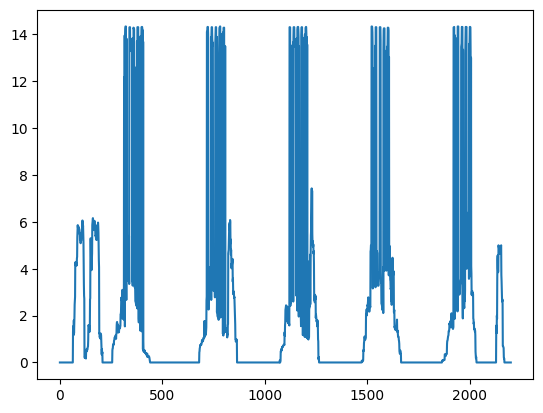

In [97]:
# Plot the list of RLE to confirm the staves positions

import matplotlib.pyplot as plt

indices = np.arange(0, array.shape[0])
plt.plot(indices, run_length_encoding[0])

In [3]:
# Get max value of MLE list
max_encoding = np.max(run_length_encoding)


# Get potential indices for the staves
# It is recognized by compare the RLE of each pixel to the the max_encoding value
# (multiplied with a coeff to ensure that we get all the potential indices of the staves)
img_indices = []
encoding_values = []
for i in range(run_length_encoding.shape[1]):
    if run_length_encoding[0][i] >= max_encoding * .7:
        img_indices.append(i)

print(img_indices)

# Calculate the biggest range possible between staves
biggest_range = 0
for i in range(len(img_indices) - 1):
    range_between = abs(img_indices[i] - img_indices[i + 1])
    biggest_range = max(biggest_range, range_between)

# Then use it to get all the start and end indices of each staff
staffs_index = []
start_index = 0
for i in range(1, len(img_indices) - 1):
    if i == (len(img_indices) - 2):
        staffs_index.append((img_indices[start_index], img_indices[len(img_indices) - 1]))
        break
    range_between = abs(img_indices[i] - img_indices[i + 1])
    if range_between >= biggest_range * .9:
        staffs_index.append((img_indices[start_index], img_indices[i]))
        start_index = i + 1
    

print(staffs_index)

[352, 353, 355, 357, 359, 360, 362, 364, 366, 367, 377, 378, 379, 383, 386, 388, 390, 391, 401, 403, 406, 528, 532, 533, 534, 544, 545, 547, 549, 551, 552, 554, 556, 558, 559, 568, 570, 571, 572, 574, 578, 581, 583, 712, 713, 715, 717, 719, 720, 724, 725, 726, 737, 738, 739, 743, 744, 746, 748, 750, 751, 761, 763, 766, 888, 892, 893, 894, 904, 905, 907, 909, 911, 912, 913, 915, 917, 918, 929, 930, 931, 935, 938, 940, 942, 943, 1072, 1073, 1075, 1077, 1079, 1080, 1084, 1085, 1086, 1097, 1098, 1100, 1102, 1103, 1104, 1106, 1108, 1110, 1111, 1121, 1122, 1123, 1127, 1248, 1252, 1253, 1254, 1264, 1265, 1267, 1269, 1271, 1272, 1273, 1275, 1277, 1278, 1289, 1290, 1291, 1295, 1296, 1298, 1300, 1302, 1303, 1432, 1433, 1435, 1437, 1439, 1440, 1444, 1445, 1446, 1457, 1458, 1460, 1462, 1463, 1464, 1466, 1468, 1470, 1471, 1481, 1482, 1483, 1487, 1609, 1612, 1614, 1624, 1625, 1627, 1629, 1631, 1632, 1636, 1637, 1638, 1649, 1650, 1651, 1655, 1656, 1658, 1660, 1662, 1663, 1792, 1794, 1797, 1800, 1804,

In [4]:
import cv2

# Generate images of single staff with the previous list of indices

staffs = []
count = 0
for pair in staffs_index:
    start = pair[0]
    end = pair[1]
    # Slice vertically
    staff = np.array(array[start:end , 0:array.shape[1]])

    # Slice horizontally (to get rid of adundant white spaces)
    for i in range(staff.shape[1] - 1):
        columns = array[start - int(biggest_range/4):end + 1 + int(biggest_range/4), i:i + 1]
        average_pixel_of_column = np.average(columns)
        if average_pixel_of_column < 250:
            start_x = i
            break

    for i in range(staff.shape[1] - 1, 0, -1):
        columns = array[start - int(biggest_range/4):end + 1 + int(biggest_range/4), i - 1:i]
        average_pixel_of_column = np.average(columns)
        if average_pixel_of_column < 250: 
            end_x = i
            break
    staff = np.array(array[start - int(biggest_range/4):end +1 + int(biggest_range/4), start_x:end_x])

    # Append staff to list of staves
    staffs.append(staff)
    #staff= cv2.copyMakeBorder(staff, 100, 100, 0, 0, 0, value=[255,255,255])
    # Save the staff to image
    img = Image.fromarray(staff)
    

    # Logic to generate the image filename
    img.save(f'staffs\\{filename}_staff_{str(count)}.jpg')
    count += 1

In [23]:
# Use the template matching method of OpenCV and Tesseract
# to identify notes and box them
import os
import cv2
import pytesseract
import numpy as np

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# file = f'staffs\\{filename}_staff_0.jpg'
file = "E:\\OneDrive - nhg.vn\\CNTT_HongBang\\HK7\\Major Project\\dataset\\raw_data\\0.png"

img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
# Pad the staff with white spaces vertically,
# so we can box the note with the whole staff,
# even in cases where the note is on the ledger line
#img= cv2.copyMakeBorder(img, 100, 100, 0, 0, 0, value=[255,255,255])

cv2.imwrite('padded_img.png', img) # print testing
img2 = img.copy() # get a copy, so we can process multi templates

# The template to be matched
template = cv2.imread('template\\roots\\solid-note.png', cv2.IMREAD_GRAYSCALE)
# Scale the template to the image's height, to prevent out of bound
#template = cv2.resize(template,(0,0),fx=img.shape[0]/template.shape[0],fy=img.shape[0]/template.shape[0])
template_copy = template.copy()
coeff = 0.9 # Best coefficient for testing
res_max = 0.8
template = cv2.resize(template,(0,0),fx=coeff,fy=coeff) #scale the tepmplate to the best coeff


# List of matching methods for testing
# methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
#             'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']

w, h = template.shape[::-1] # Get w and h of template
img = img2.copy() # Get a copy to process

res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # Begin matching and get matches
threshold = res_max - 0.13
loc = np.where(res >= threshold) # With threshold to offset the difference between template and notes (with staff)

# Get a set of center indices of boxes for further testing
indices = set()
list_pt = {}
for pt in zip(*loc[::-1]):
    x = int(pt[0] + w/2)
    upper_bound = int(x + template.shape[1]/5)
    lower_bound = int(x - template.shape[1]/5)
    found = False
    for i in range(lower_bound, upper_bound):
        if(i in indices):
            found = True
            break
    if not found:
        list_pt[x] = pt
        indices.add(x)

for x in indices:
    pt = list_pt[x]
    cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

print(indices)
cv2.imwrite('res.png', img)

{736, 705, 610, 673, 324, 800, 769, 642, 488, 367, 210, 533, 278, 414}


True

In [240]:
print()

(1368,)


In [20]:
# Brute force algorithm to find the best scaling for the template
# We scale the template up and down until we find an optimal coefficient
# that give us the most matches in the image
# Notes: this isn't tested in cases where the number of matches exceed the number of correct notes,
# since we only test one type of note (quarter)
# It should be fine until there are simmilar types of notes (quarter and linked-stem eight)

res_max_global = 0.8
best_coeff = 1
max_matches = 0

###################Decreasing:
for i in range(5):
    template = template_copy.copy()
    img = img2.copy()
    # Scaling coeff in range [0.2, 1] with step = 0.1
    coeff = 1 - i/10.0
    template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    res_max = res.max()

    threshold = res_max_global * 0.85
    loc = np.where(res >= threshold)
    indices = set()
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
        x = int(pt[0] + w/2)
        cv2.rectangle(img, (x, 0), (x, img.shape[1]), (0, 255, 0), 2)
        upper_bound = int(x + template.shape[1]/5)
        lower_bound = int(x - template.shape[1]/5)
        found = False
        for i in range(lower_bound, upper_bound):
            if i in indices: 
                found = True
                break
        if not found:
            indices.add(x)
    if len(indices) > max_matches and res_max >= res_max_global:
        max_matches = len(indices)
        best_coeff = coeff
            

###################Increasing:
for i in range(5):
    template = template_copy.copy()
    img = img2.copy()
    # Scaling coeff in range [1, 1.8] with step = 0.1
    coeff = 1 + i/10.0
    template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
    w, h = template.shape[::-1]
    if(template.shape[0] > img.shape[0]): break

    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    res_max = res.max()

    threshold = res_max_global * 0.85
    loc = np.where(res >= threshold)
    indices = set()
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
        x = int(pt[0] + w/2)
        cv2.rectangle(img, (x, 0), (x, img.shape[1]), (0, 255, 0), 2)
        upper_bound = int(x + template.shape[1]/5)
        lower_bound = int(x - template.shape[1]/5)
        found = False
        for i in range(lower_bound, upper_bound):
            if(i in indices): 
                found = True
                break
        if not found:
            indices.add(x)
    if len(indices) > max_matches and res_max >= res_max_global:
        max_matches = len(indices)
        best_coeff = coeff

print(f"res_max_global:{res_max_global}")
print(f"best_coeff:{best_coeff}")

res_max_global:0.8
best_coeff:0.9


In [57]:
def find_best_coeff(template, img2, res_max_global):
    best_coeff = 1
    template_copy = template

    ###################Decreasing:
    for i in range(7):
        template = template_copy
        img = img2.copy()
        # Scaling coeff in range [0.2, 1] with step = 0.1
        coeff = 1 - i/10.0
        template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
        w, h = template.shape[::-1]

        res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
        res_max = res.max()

        threshold = res_max_global
        loc = np.where(res >= threshold)
        indices = set()
        for pt in zip(*loc[::-1]):
            x = int(pt[0] + w/2)
            upper_bound = x + 30
            lower_bound = x - 30
            found = False
            for i in range(lower_bound, upper_bound):
                if i in indices:
                    found = True
                    break
            if not found:
                indices.add(x)
        if res_max >= res_max_global:
            res_max_global = res_max
            best_coeff = coeff
                

    # ###################Increasing:
    # for i in range(7):
    #     img = img2.copy()
    #     # Scaling coeff in range [1, 1.8] with step = 0.1
    #     coeff = 1 + i/10.0
    #     template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
    #     w, h = template.shape[::-1]
    #     if(template.shape[0] > img.shape[0]): break

    #     res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    #     res_max = res.max()

    #     threshold = res_max_global
    #     loc = np.where(res >= threshold)
    #     indices = set()
    #     for pt in zip(*loc[::-1]):
    #         x = int(pt[0] + w/2)
    #         upper_bound = x + 30
    #         lower_bound = x - 30
    #         found = False
    #         for i in range(lower_bound, upper_bound):
    #             if(i in indices): 
    #                 found = True
    #                 break
    #         if not found:
    #             indices.add(x)
    #     if res_max >= res_max_global:
    #         res_max_global = res_max
    #         best_coeff = coeff
    return(res_max_global, best_coeff)

In [62]:
# Use the template matching method of OpenCV and Tesseract
# to identify notes and box them
import os
import cv2
import pytesseract
import numpy as np

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

#file = f'{filename}_staff_0.jpg'
file = "dataset\\raw_data\\3.png"

img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
# Pad the staff with white spaces vertically,
# so we can box the note with the whole staff,
# even in cases where the note is on the ledger line
# img = cv2.copyMakeBorder(img, 100, 100, 0, 0, 0, value=[255,255,255])
# cv2.imwrite('padded_img.png', img) # print testing
img2 = img.copy() # get a copy, so we can process multi templates

# The template to be matched
template = cv2.imread(f'template\\time\\common.jpg', cv2.IMREAD_GRAYSCALE)


# Scale the template to the image's height, to prevent out of bound
template = cv2.resize(template,(0,0),fx=img.shape[0]/template.shape[0],fy=img.shape[0]/template.shape[0])
template_copy = template.copy()

res_max, coeff = find_best_coeff(template, img2, 0.5)# Best coefficient for testing

template = cv2.resize(template,(0,0),fx=coeff,fy=coeff) #scale the tepmplate to the best coeff


# List of matching methods for testing
# methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
#             'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']

w, h = template.shape[::-1] # Get w and h of template
img = img2.copy() # Get a copy to process

res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # Begin matching and get matches
threshold = res_max
print(f"threshold:{threshold}")
loc = np.where(res >= threshold) # With threshold to offset the difference between template and notes (with staff)

# Get a set of center indices of boxes for further testing
indices = set()
list_pt = {}
for pt in zip(*loc[::-1]):
    x = int(pt[0] + w/2)
    print(x)
    upper_bound = x + 10
    lower_bound = x - 10
    found = False
    for i in range(lower_bound, upper_bound):
        if(i in indices):
            found = True
            break
    if not found:
        list_pt[x] = pt
        indices.add(x)

print(f"{len(indices)} matches")
for x in indices:
    pt = list_pt[x]
    cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res_all_notes.png', img)

threshold:0.5847151875495911
159
1 matches


True